# Reduced coverage experiments
Where the set of entries contrained in one thesaurus is constrained to match another, smaller thesaurus. This lets us look at performance differences due to 

 - higher coverage of space of all words/phrases (due to different filtering or algorithm specifics), versus 
 - better vector quality
 
There are currently (19-5-15) two sets of such experiments, both for NPs only:
 - w2v vectors reduced to the coverage of count-windows vectors
 - count-windows reduced to coverage of Baroni vector

In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from copy import deepcopy
from notebooks.common_imports import *
from gui.output_utils import *
from gui.user_code import pretty_names
from pprint import pprint

sns.timeseries.algo.bootstrap = my_bootstrap
sns.categorical.bootstrap = my_bootstrap

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [2]:
def plot_matching(exp_with_constraints, labels=None, rotation=0):
    matching = []
    for e in exp_with_constraints:
        settings = settings_of(e.id)
        settings['expansions__entries_of_id'] = None
        matching.append(Experiment.objects.get(**settings))
    
    ids1 = list(exp_with_constraints.values_list('id', flat=True))
    ids2 = [x.id for x in matching]
    print(ids1, '--->', ids2)
    if not labels:
        labels = ['%s-%s'%(a.id, b.id) for a,b in zip(exp_with_constraints, matching)]
    with sns.color_palette("cubehelix", 2):
        diff_plot_bar([ids1, ids2], ['Limited', 'Unlimited'],
                      labels, rotation=rotation, hue_order=['Unlimited', 'Limited'],
                     legend_title='Coverage')

# count windows vectors (add, mult, ...) reduced to Baroni's coverage
we know they are better and have a higher coverage, so can reducing the coverage reduce the accuracy too

[188, 190, 192, 194] ---> [27, 28, 29, 30]


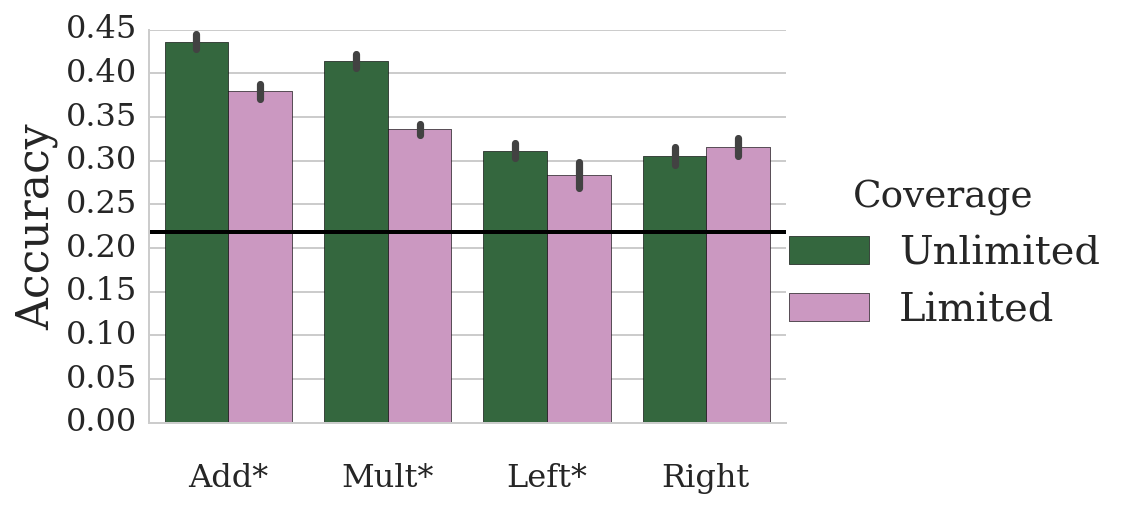

In [3]:
experiments = Experiment.objects.filter(expansions__entries_of__isnull=False, 
                                        expansions__entries_of__composer='Baroni')
names = [n.expansions.vectors.composer for n in experiments]

plot_matching(experiments, labels=names)
plt.axhline(random_vect_baseline(), c='k');
plt.savefig('plot-reduced-coverage1.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# word2vec reduced to coverage of count windows (there shouldn't be a large difference)

[187, 189, 191, 193] ---> [34, 35, 36, 37]


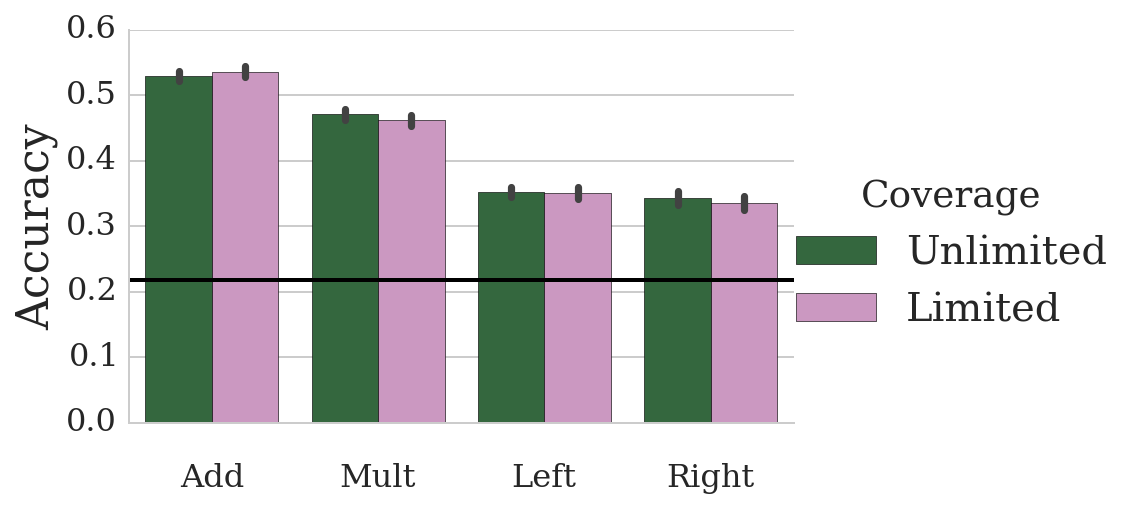

In [4]:
exp_ids = Experiment.objects.filter(expansions__entries_of__isnull=False,
                                    expansions__entries_of__algorithm='count_windows'
                                   ).exclude(expansions__entries_of__composer='Baroni')
names = [n.expansions.vectors.composer for n in exp_ids]
plot_matching(exp_ids, labels=names)
plt.axhline(random_vect_baseline(), c='k');
plt.savefig('plot-reduced-coverage2.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# wiki-100 reduced to coverage of wiki-15 

[282, 283, 284, 285] ---> [34, 35, 36, 37]


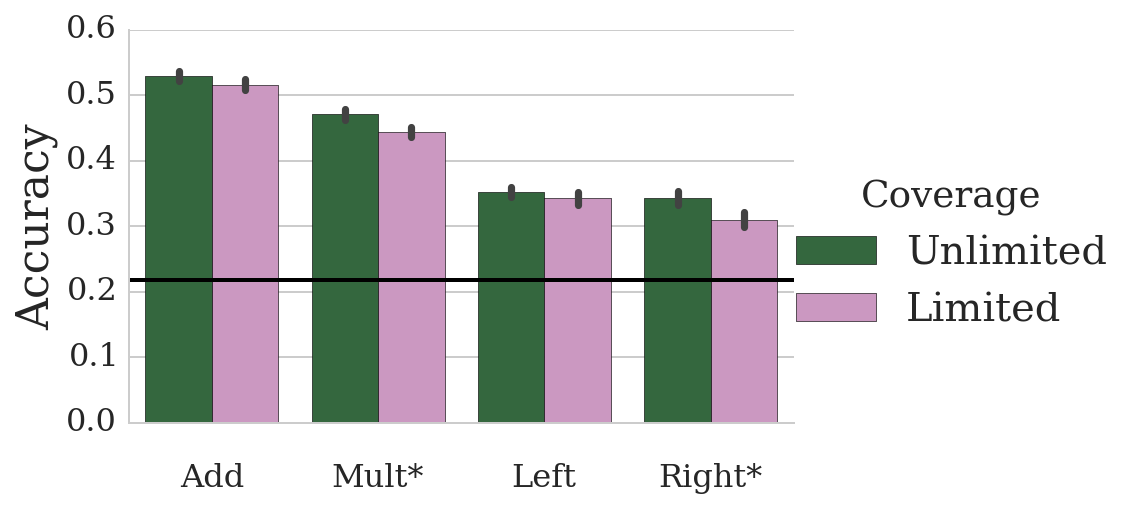

In [5]:
exp_ids = Experiment.objects.filter(expansions__entries_of__isnull=False,
                                    expansions__vectors__unlabelled_percentage=100,
                                    expansions__entries_of__unlabelled_percentage=15)
names = [n.expansions.vectors.composer for n in exp_ids]
plot_matching(exp_ids, labels=names)
plt.axhline(random_vect_baseline(), c='k');
plt.savefig('plot-reduced-coverage3.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Learning curve with reduced coverage
An extended version of the above cell

In [6]:
constrained_exp_ids = Experiment.objects.filter(expansions__entries_of__isnull=False,
                                    expansions__entries_of__unlabelled_percentage__in=[1, 10],
                                    expansions__vectors__composer='Add').values_list('id', flat=True)
print(constrained_exp_ids)

[324, 325, 326, 327, 328, 329, 330, 331, 332, 333]


In [7]:
unconstrained_exp_ids = set()
for eid in constrained_exp_ids:
    s = settings_of(eid)
    s['expansions__entries_of_id'] = None
    del s['expansions__vectors__unlabelled_percentage']
    unconstrained_exp_ids.update(set(Experiment.objects.filter(**s).values_list('id', flat=True)))
print(unconstrained_exp_ids, '-->', constrained_exp_ids)

{34, 101, 102, 103, 104, 105, 106, 75} --> [324, 325, 326, 327, 328, 329, 330, 331, 332, 333]


In [8]:
# notation from thesis
names = {'N':'expansions__vectors__unlabelled_percentage',
         'M':'expansions__entries_of__unlabelled_percentage'}
df1 = dataframe_from_exp_ids(unconstrained_exp_ids, names)
# df1['kind'] = 'Unlimited'
df2 = dataframe_from_exp_ids(constrained_exp_ids, names)
# df2['kind'] = 'Limited'

Accuracy has 4000 values
folds has 4000 values
M has 4000 values
N has 4000 values
Accuracy has 5000 values
folds has 5000 values
M has 5000 values
N has 5000 values


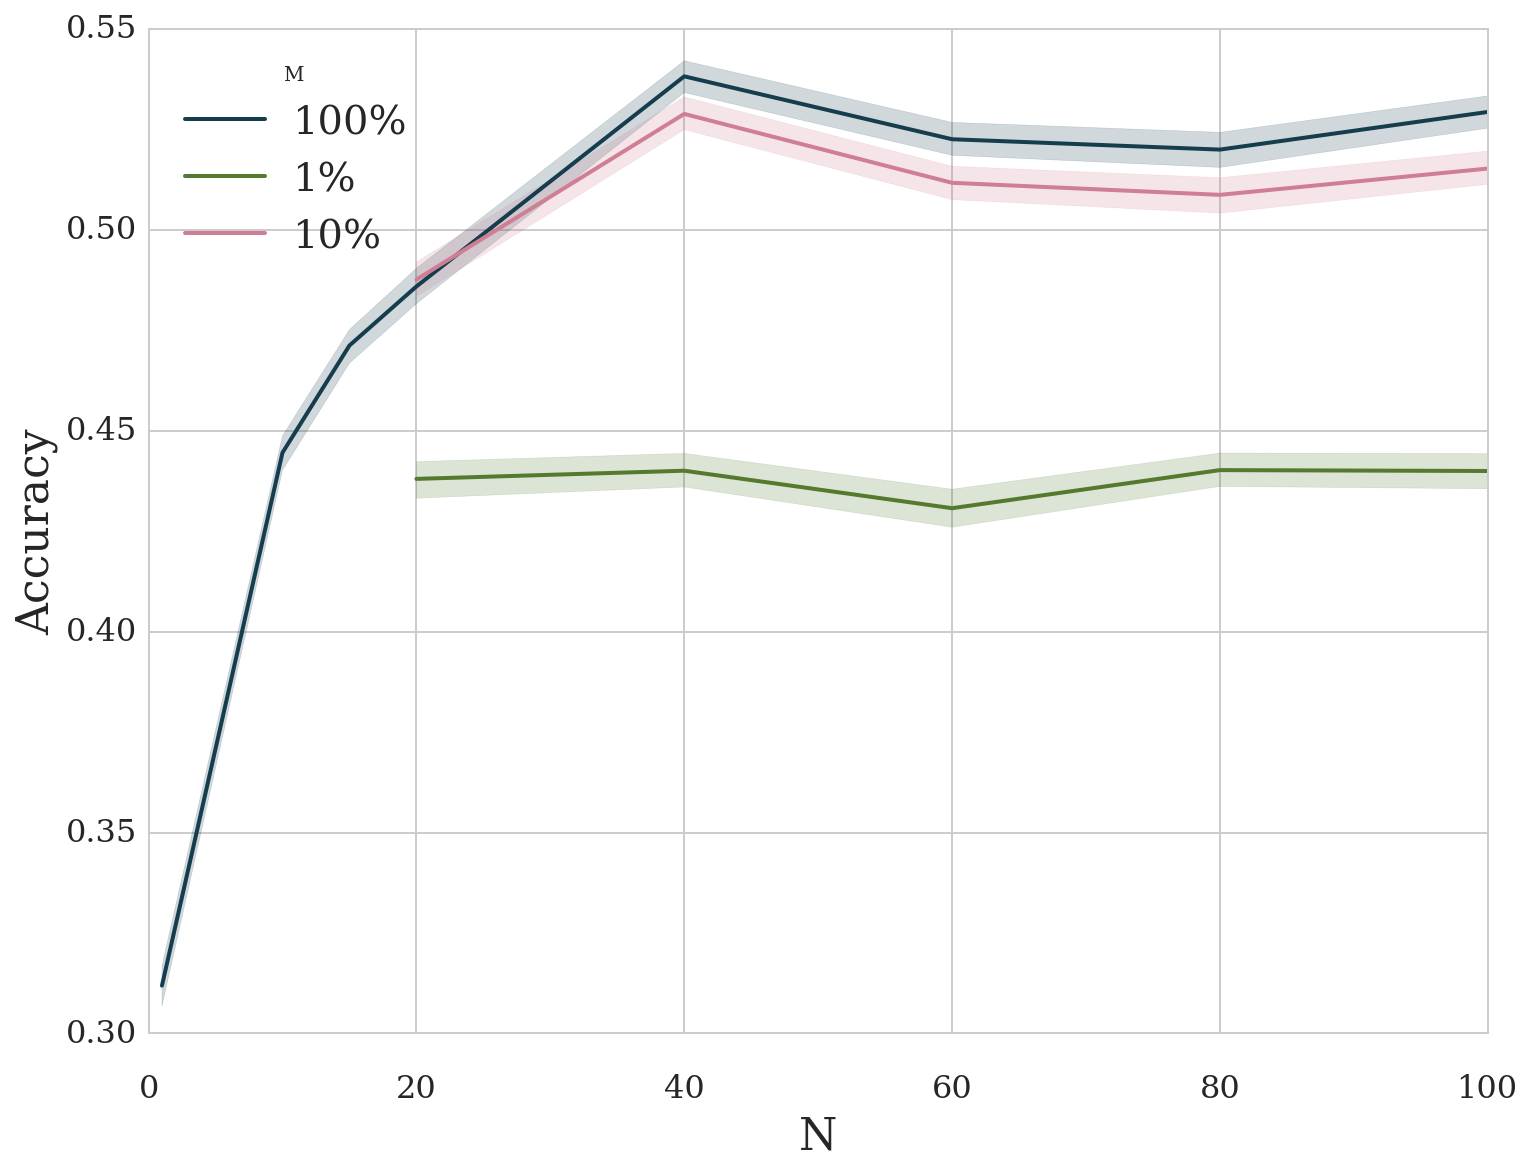

In [9]:
df = pd.concat([df1, df2], ignore_index=True).convert_objects(convert_numeric=True).fillna(100)
# df['Tokens'] = df.percent * 1500000000 / 100
df.M = df.M.astype(int).astype(str) + '%'
with sns.color_palette("cubehelix", 4):
    ax = sns.tsplot(df, time='N', unit='folds', condition='M', value='Accuracy')
plt.xlim(0, df.N.max())
# plt.axvline(15 * 1500000000/ 100, color='red', linestyle='dotted');
# plt.axvline(1 * 1500000000/ 100, color='green', linestyle='dotted');
plt.savefig('plot-learning-curve-with-reduction.pdf', format='pdf', dpi=300)